# Librearies

In [121]:
import os
import sys
import json
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.stats import wasserstein_distance

In [2]:
sys.path.append(os.path.abspath('..'))

In [3]:
from src.models.meta.vanilla_vae import Vanilla_VAE
from src.models.meta.vanilla_gan import Vanilla_GAN
from src.models.meta.meta_vae import Meta_VAE
from src.models.meta.smvae import SMVAE
from src.models.marginals.vae import VAE
from src.dataset.meta_dataloaders import DataModule as metaDm

In [4]:
saved_models_path = os.path.join(os.path.abspath('..'),'saved_models')

In [5]:
device = torch.device('cpu')

# Utils

In [6]:
def not_trainable(model):
    for param in model.parameters():
        param.requires_grad = False

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def load_models(n,models_path):
    models_list = []
    for i in range(n):
        for f in os.listdir(models_path):
            filename = os.fsdecode(f)
            if filename.endswith("_{}".format(i)):
                load_path = os.path.join(models_path,filename)
                model = torch.load(load_path,map_location = device)
                n_parameters = count_parameters(model)
                print(filename, 'n_parameters: ',n_parameters)
                not_trainable(model)
                models_list.append(model)
    return models_list

# Dataset 

In [9]:
dm = metaDm()
dm.setup()
# test loader for the Meta-VAE and SMVAE, the loaded data is in the form
# (nested cylinders, hyperparameters, inner density, outer density)
test_dataloader = dm.exp_dataloader()

In [10]:
dm = metaDm(whole_system=True)
dm.setup()
# test loader for the Vanilla VAE and Vanilla GAN, the loaded data is in the form (system, hyperparameters)
vvae_test_loader = dm.exp_dataloader()

# Marginal models

## Marginal VAEs 

In [11]:
# Load marginal models
marginals_path = os.path.join(saved_models_path,'marginal_generators')
density_vae = torch.load(os.path.join(marginals_path,'densities','model_0'),map_location=torch.device(device))
cylinder_vae = torch.load(os.path.join(marginals_path,'cylinders','model_0'),map_location=torch.device(device))

In [12]:
# Make the models untrainable
not_trainable(density_vae)
not_trainable(cylinder_vae)

# Meta Models

## Vanilla GAN

In [13]:
gan_path = os.path.join(saved_models_path,"vanilla_gan","fair")

In [14]:
gan_list = load_models(5,gan_path)

model_0 n_parameters:  293473
model_1 n_parameters:  293473
model_2 n_parameters:  293473
model_3 n_parameters:  293473
model_4 n_parameters:  293473


## Vanilla VAE

In [15]:
vvae_path = os.path.join(saved_models_path,"vanilla_vae","fair")

In [16]:
vvae_list = load_models(5,vvae_path)

model_0 n_parameters:  294180
model_1 n_parameters:  294180
model_2 n_parameters:  294180
model_3 n_parameters:  294180
model_4 n_parameters:  294180


## SMVAE

### Load SMVAE models

In [126]:
svae_path = os.path.join(saved_models_path,"smvae","1k_train")

In [127]:
svae_list = load_models(5,svae_path)

model_0 n_parameters:  300592
model_1 n_parameters:  300592
model_2 n_parameters:  300592
model_3 n_parameters:  300592
model_4 n_parameters:  300592


## Meta VAE 

### Load Meta-VAE models

In [19]:
mvae_path = os.path.join(saved_models_path,"meta_vae")

In [20]:
mvae_list = load_models(5,mvae_path)

model_0 n_parameters:  277582
model_1 n_parameters:  277582
model_2 n_parameters:  277582
model_3 n_parameters:  277582
model_4 n_parameters:  277582


# Experiments

In [128]:
n_models = 5
latent_dim=4

In [129]:
all_models_dict = {'gan':gan_list,'vvae':vvae_list,'svae':svae_list, 'mvae': mvae_list}
model_name = {'gan':'Vanilla GAN','vvae':'Vanilla VAE','mvae':'Meta-VAE','svae':'SMVAE'}

## Useful fcts

### Functions to compute and plot the equilibrium and contact constraints verification

In [130]:
# Function to compute the absolute errors E_p and E_c (cf paper) and  returns some values used for the plots
def equ(r1,r2,d1,d2,h):
    m = h[:,0]
    x = h[:,1]
    y = h[:,2]
    d1 = d1[:,0,0]
    d2 = d2[:,0,0]
    ri1=r1[:,0,0]
    re1=r1[:,0,30]
    ri2=r2[:,0,0]
    re2=r2[:,0,30]
    s1=torch.pi*(re1**2-ri1**2)
    s2=torch.pi*(re2**2-ri2**2)
    m1 = s1*d1/1000 
    m2 = s2*d2/1000
    return (m1+m2)*x-m*y,re2-ri1,re1,ri1,re2,ri2,d2,d1,(m1+m2)*x,m*y

In [131]:
def sample_latent(n, latent_dim=4, sample_mode='normal', bound = None, mean = 0, std = .6): # 0.51
    if sample_mode=='normal':
        shape = (n, latent_dim)
        sample = torch.normal(mean, std, size=shape)
    else:
        sample = torch.rand((n,latent_dim))*(2*bound)-bound
    return sample

In [132]:
def generate_multiple(model_list,model_type,latent_dim=latent_dim, sample_mode = 'normal', 
                      bound=None,loader = test_dataloader, mean=0, std=.6, 
                      conditional = False, condition = None, n_cond = None):
    output_dict = {'error':[],'r_err':[],'re1':[],'ri1':[],'re2':[],'ri2':[],'d2':[],'d1':[],'mx':[],'my':[],'sample':[]}
    
    '''Load hyperparameters and test data'''
    if not conditional:
        if model_type  in ['vvae','gan']:
            loader = vvae_test_loader
            data,h = next(iter(loader))
            c,d_int,d_ext = data[:,:,:120],data[:,:,120:150],data[:,:,150:]
        else:
            c, h,d_int,d_ext = next(iter(loader))
    else:
        cond = torch.tensor([condition[0],condition[1],100-condition[1]])
        h = cond.repeat(n_cond,1).float()
        h = h.to(device)
    h = h.to(device)
    
    
    '''generations list'''
    int_gens,ext_gens,di_gens,de_gens =  [],[],[],[]
    
    
    '''latent and generation'''
    i=-1
    for model in model_list:
        i+=1
        latent = sample_latent(h.shape[0], latent_dim, sample_mode, bound, mean=mean, std=std)
        latent = latent.to(device)
        
        if model_type == 'vvae':
            recon = model._decoder(latent,h)
            int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
        elif model_type == 'gan':
            recon = model(latent,h)
            int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
        elif model_type == 'svae':
            int_gen,ext_gen,di_gen,de_gen = model._decoder(latent,h)
        else:
            z_int, z_ext, zdi,zde = model._decoder(latent,h)
            int_gen = cylinder_vae._decoder(z_int)
            ext_gen =  cylinder_vae._decoder(z_ext)
            di_gen = density_vae._decoder(zdi)
            de_gen = density_vae._decoder(zde)
            
        int_gen = int_gen.cpu().detach().numpy()
        ext_gen = ext_gen.cpu().detach().numpy()
        di_gen = di_gen.cpu().detach().numpy()
        de_gen = de_gen.cpu().detach().numpy()
        
            
        h_param = torch.clone(h)
        h_param = torch.squeeze(h_param).detach().cpu().numpy()
        error,r_err,re1,ri1,re2,ri2,d2,d1,mx,my = equ(ext_gen,int_gen,de_gen,di_gen,h_param)
        output_dict['error'].append(error)
        output_dict['r_err'].append(r_err)
        output_dict['re1'].append(re1)
        output_dict['ri1'].append(ri1)
        output_dict['re2'].append(re2)
        output_dict['ri2'].append(ri2)
        output_dict['d2'].append(d2)
        output_dict['d1'].append(d1)
        output_dict['mx'].append(mx)
        output_dict['my'].append(my)
        output_dict['sample'].append(latent.detach().numpy())
    if not conditional:
        c = c.numpy()
        c_int,c_ext = c[:,:,:60],c[:,:,60:]
        output_dict['real_ri2']=c_int[:,0,0]
        output_dict['real_re2']=c_int[:,0,30]
        output_dict['real_ri1']=c_ext[:,0,0]
        output_dict['real_re1']=c_ext[:,0,30]
        output_dict['real_d2'] = d_int[:,0,0].detach().cpu().numpy()
        output_dict['real_d1'] = d_ext[:,0,0].detach().cpu().numpy()
    output_dict['h_param'] = h_param
    return output_dict

In [133]:
def plot_errors(sample_mode = 'normal', bound = .1, mean=0, std=.6,
               conditional = False, condition = None, n_cond = None):
    all_errors = {}
    for k,v in all_models_dict.items(): 
        all_errors[k] = generate_multiple(v,k,sample_mode = sample_mode, bound=bound,loader = test_dataloader, mean=mean,
                                          std=std, conditional = conditional, condition = condition, n_cond = n_cond)
    fig, ax = plt.subplots(figsize = (20,10),nrows=3, ncols=4)
    i=0
    for k,v in tqdm(all_errors.items()):
        err = np.reshape(np.array(v['error']),(1,-1))[0,:]
        r_err = np.reshape(np.array(v['r_err']),(1,-1))[0,:]
        ax[0][i].hist(err,bins=500)#,alpha = .2)
        ax[0][i].axvline(x = 0, color = 'r',linestyle='--')
        ax[0][i].set_title(model_name[k])
        xlim  = [-5000,5000] if k!='gan' else [-25000,25000]
        ax[0][i].set_xlim(xlim)
        
        ax[1][i].hist(r_err,bins=500)
        ax[1][i].axvline(x = 0, color = 'r',linestyle='--')
        xlim  = [-2,2] if k!='gan' else [-50,50]
        ax[1][i].set_xlim(xlim)
        
        x=np.reshape(np.array(v['mx']),(1,-1))
        y=np.reshape(np.array(v['my']),(1,-1))
        ax[2][i].scatter(x[0,:],y[0,:])
        ax[2][i].axline((0, 0), slope=1,color='r')
        ax[2][0].set_xlabel(r'$x\times m_{generated}$')
        ax[2][0].set_ylabel(r'$y\times m_{cube}$')
        i+=1
    fig.suptitle(r'Histograms of $E_p$ and $E_c$ and residual plots of $E_p$')
    plt.show()

In [134]:
def plot_box_plots(whis=1.5,sample_mode = 'normal', bound = .1, linthresh=None, mean=0, std=.6,
                  conditional = False, condition = None, n_cond = None):
    all_errors = {}
    for k,v in all_models_dict.items():
        all_errors[k] = generate_multiple(v,k,sample_mode = sample_mode, bound=bound, mean=mean, std=std,
                                         conditional = conditional, condition = condition, n_cond = n_cond)
    model_types = list(all_errors.keys())
    
    fig, ax = plt.subplots(figsize = (20,10),nrows=1, ncols=2)
    err = [np.concatenate(all_errors[model_type]['error']) for model_type in model_types]
    ax[0].boxplot(err, whis=whis,showfliers=False, labels=[model_name[m] for m in model_types])
    ax[0].set_xlabel('Model Types')
    ax[0].set_ylabel(r'$E_p$')
    ax[0].set_title(r'Box Plot of $E_p$ for Different Model Types')
    if linthresh:
        ax[0].set_yscale('symlog',linthresh=linthresh[0])     
    err = [np.concatenate(all_errors[model_type]['r_err']) for model_type in model_types]
    ax[1].boxplot(err, whis=whis,showfliers=False, labels=[model_name[m] for m in model_types])
    ax[1].set_xlabel('Model Types')
    ax[1].set_ylabel(r'$E_p$')
    ax[1].set_title(r'Box Plot of $E_c$ for Different Model Types')
    if linthresh:
        ax[1].set_yscale('symlog',linthresh=linthresh[1]) 
                     
    plt.show()

### Wasserstein distance computation and plots

In [135]:
def compute_wasserstein_distance(real_x, real_y, generated_x, generated_y, bins):
    # Compute the 2D histograms for real and generated data
    maxx, minx = max(real_x),min(real_x)
    maxy, miny = max(real_y),min(real_y)
    
    idx = np.where((generated_x >= minx) & (generated_x <= maxx) & (generated_y >= miny) & (generated_y <= maxy))

    
    generated_x = generated_x[idx]
    generated_y = generated_y[idx]


    real_hist_2d, _, _ = np.histogram2d(real_x, real_y, bins=bins)
    generated_hist_2d, _, _ = np.histogram2d(generated_x, generated_y, bins=bins)
     
    # Normalize the histograms
    # real_hist_2d /= real_hist_2d.sum()
    # generated_hist_2d /= generated_hist_2d.sum()
 
    # Flatten the 2D histograms into 1D arrays
    real_hist_flat = real_hist_2d.flatten()
    generated_hist_flat = generated_hist_2d.flatten()
 
    # Compute the Wasserstein distance between the flattened histograms
    distance = wasserstein_distance(real_hist_flat, generated_hist_flat)
    
    return distance


In [136]:
def get_errors_dico(all_models_dict,with_gan, sample_mode = 'normal', bound = .1):
    dico = {}
    for k,v in all_models_dict.items():
        if k!='gan' or with_gan:
            dico[k] = generate_multiple(v,k,sample_mode = sample_mode, bound=bound)#[bound for i in range(n_models)])
    return dico

In [137]:
def plot_wasserstein_errorbars(sample_mode ='normal',bound = 2, denity_sample_mode ='normal', density_bound = 1, 
                               best_model='mvae', highlight_best_model=True, with_gan=False):
    parameter_pairs = [('re1', 're2'),  ('re1', 'ri2'), ('re1', 'ri1'),  ('d1', 'd2')]
    dico = get_errors_dico(all_models_dict,with_gan,sample_mode, bound)
    model_types = list(dico.keys())
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for i, (param1, param2) in enumerate(parameter_pairs):
        real_param1 = f'real_{param1}'
        real_param2 = f'real_{param2}'
        bins = 100
        if param1 == 'd1':
            dico = get_errors_dico(all_models_dict,sample_mode, denity_sample_mode, density_bound)
        wasserstein_distances = {}
        for model_type, model_data in dico.items():
            model_distances = []
            for p1, p2 in zip(model_data[param1], model_data[param2]):
                distance = compute_wasserstein_distance( model_data[real_param1], model_data[real_param2],p1, p2,
                                                        bins=50)
                model_distances.append(distance)
            wasserstein_distances[model_type] = model_distances
            
        #Compute gaussian noise
        p1 = np.random.normal(0,1,size= model_data[real_param1].shape)
        p2 = np.random.normal(0,1,size= model_data[real_param1].shape)
     
        means = [np.mean(wasserstein_distances[model]) for model in model_types]
        std_devs = [np.std(wasserstein_distances[model]) for model in model_types]

        ax = axs[i // 2, i % 2]
        ax.errorbar([model_name[m] for m in model_types], means, yerr=std_devs, fmt='o', capsize=5)

        if highlight_best_model and best_model in wasserstein_distances:
            best_mean = np.mean(wasserstein_distances[best_model])
            ax.axhline(y=best_mean, color='r', linestyle='--')

        ax.set_xlabel('Model Type')
        ax.set_ylabel('Wasserstein Distance')
        ax.set_title(f'Wasserstein Distances for {param1} and {param2}')
    ('d1', 'd2'),

    plt.tight_layout()
    plt.show()

### Function to plot the joint distributions

In [138]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, model_type, 
                 scatter_alpha=0.5,hist_alpha=0.5, xlim=None, ylim=None,scatter_color = 'C0',hist_color = 'C0'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=scatter_alpha,color = scatter_color)
    ax.set_title(model_name[model_type], fontsize=15)

    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    binwidth = 0.25
    xy_min = min(np.min(x), np.min(y))
    xy_max = max(np.max(x), np.max(y))
    
    bins = np.arange(xy_min, xy_max + binwidth, binwidth)   
    ax_histx.hist(x, bins=bins, alpha=hist_alpha,color = hist_color,density=True)
    ax_histy.hist(y, bins=bins,  alpha=hist_alpha, orientation='horizontal', color=hist_color, density=True)

In [139]:
 def plot_joint_marginal_distributions(parameter_i, parameter_j,x_label,y_label, real_parameter_i=None, 
                                       real_parameter_j=None, xlim=None,ylim=None,sample_mode ='normal',bound = None,
                                      conditional = False, condition = None, n_cond = None):
    dico = {}
    for k,v in all_models_dict.items():
        dico[k] = generate_multiple(v,k,sample_mode =sample_mode,bound = bound,
                                   conditional = conditional, condition = condition, n_cond = n_cond)
        
    
    fig = plt.figure(figsize=(6 * len(dico), 6))
    outer_grid = gridspec.GridSpec(1, len(dico), wspace=0.3)
 
    for model_type_idx, model_type in enumerate(dico):
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid[model_type_idx],
                                                      width_ratios=(4, 1), height_ratios=(1, 4),
                                                      wspace=0.1, hspace=0.2)
 
        x = np.concatenate(dico[model_type][parameter_i])
        y = np.concatenate(dico[model_type][parameter_j])
         
        if not conditional:
            x_real = dico[model_type][real_parameter_i]
            y_real = dico[model_type][real_parameter_j]
 
        ax = fig.add_subplot(inner_grid[1, 0])
        ax_histx = fig.add_subplot(inner_grid[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(inner_grid[1, 1], sharey=ax)
        
        if not conditional:
            scatter_hist(x_real, y_real, ax, ax_histx, ax_histy, f"{model_type}", 
                         scatter_alpha=.5, hist_alpha=.5, xlim=xlim,ylim=ylim,
                         scatter_color = 'orange',hist_color = 'orange'  )
        scatter_hist(x, y, ax, ax_histx, ax_histy, f"{model_type}",
                      scatter_alpha=.05, hist_alpha=.5,xlim=xlim,ylim=ylim)
        
        if True:
            ax.set_xlabel(x_label,fontsize=15)
            ax.set_ylabel(y_label,fontsize=15)
 
    plt.show()

### Function to plot new generations

In [140]:
def plot(model,model_type,
         n1=4,n2=4,latent_dim=latent_dim,is_cylinders=True, sample_mode='normal', bound=.5,loader = test_dataloader,
        conditional = False, condition = None):
    if not conditional:
        _,h,_,_ = next(iter(loader))
        h = h[:n1*n2]
    else:
        cond = torch.tensor([condition[0],condition[1],100-condition[1]])
        h = cond.repeat(n1*n2,1).float()
    h = h.to(device)
    latent = sample_latent(h.shape[0], latent_dim, sample_mode, bound)
    latent = latent.to(device)
    if model_type == 'vvae':
        recon = model._decoder(latent,h)
        int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
    elif model_type == 'gan':
        recon = model(latent,h)
        int_gen, ext_gen, di_gen, de_gen = recon[:,:,:60],recon[:,:,60:120],recon[:,:,120:150],recon[:,:,150:]
    elif model_type == 'svae':
        int_gen,ext_gen,di_gen,de_gen = model._decoder(latent,h)
    else:
        z_int, z_ext, zdi,zde = model._decoder(latent,h)
        int_gen = cylinder_vae._decoder(z_int)
        ext_gen =  cylinder_vae._decoder(z_ext)
        di_gen= density_vae._decoder(zdi)
        de_gen= density_vae._decoder(zde)
    
    int_gen = int_gen.cpu().detach().numpy()
    ext_gen = ext_gen.cpu().detach().numpy()
    di_gen = di_gen.cpu().detach().numpy()
    de_gen = de_gen.cpu().detach().numpy()
    fig, axes = plt.subplots(figsize = (2.5*n1,2.5*n2),nrows=n2, ncols=n1)
    k=0
    for i in range(n2):
        for j in range(n1):
            if is_cylinders:
                lim = 120
                axes[i][j].scatter(int_gen[k,0,:],int_gen[k,1,:],s=5,c='orange')
                axes[i][j].scatter(ext_gen[k,0,:],ext_gen[k,1,:],alpha=0.2, c = 'b')   
            else:
                lim = 15
                axes[i][j].scatter(di_gen[k,0,:],di_gen[k,1,:],s=5,c='tomato')
                axes[i][j].scatter(de_gen[k,0,:],de_gen[k,1,:],alpha=0.2, c = 'darkblue')  
                axes[i][j].set_title(r' $d_2 =$ '+str(round(di_gen[k,0,0],2))+ r' $d_1 =$'+str(round(de_gen[k,0,0],2)),
                                     fontsize = 7)
            axes[i][j].set_xlim([-lim,lim])
            axes[i][j].set_ylim([-lim,lim])  
            k+=1
    plt.show()

# Non conditional generation

## Plots

### Errors and distributions plots

100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


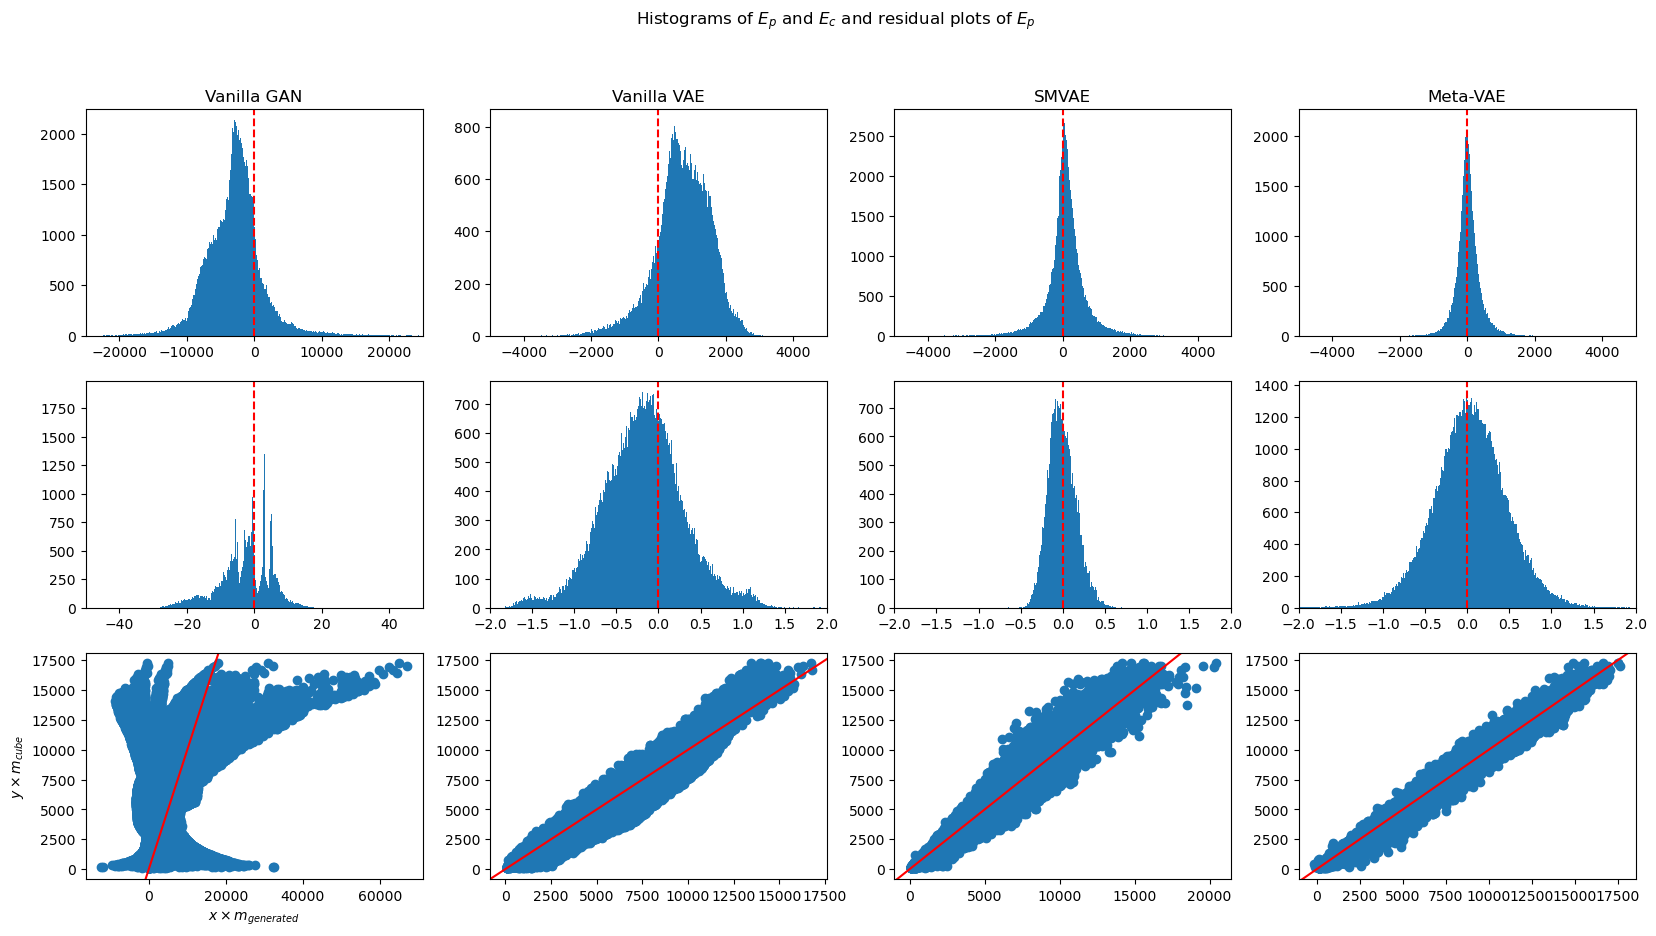

In [141]:
plot_errors(sample_mode = 'normal', mean=0, std=.3)

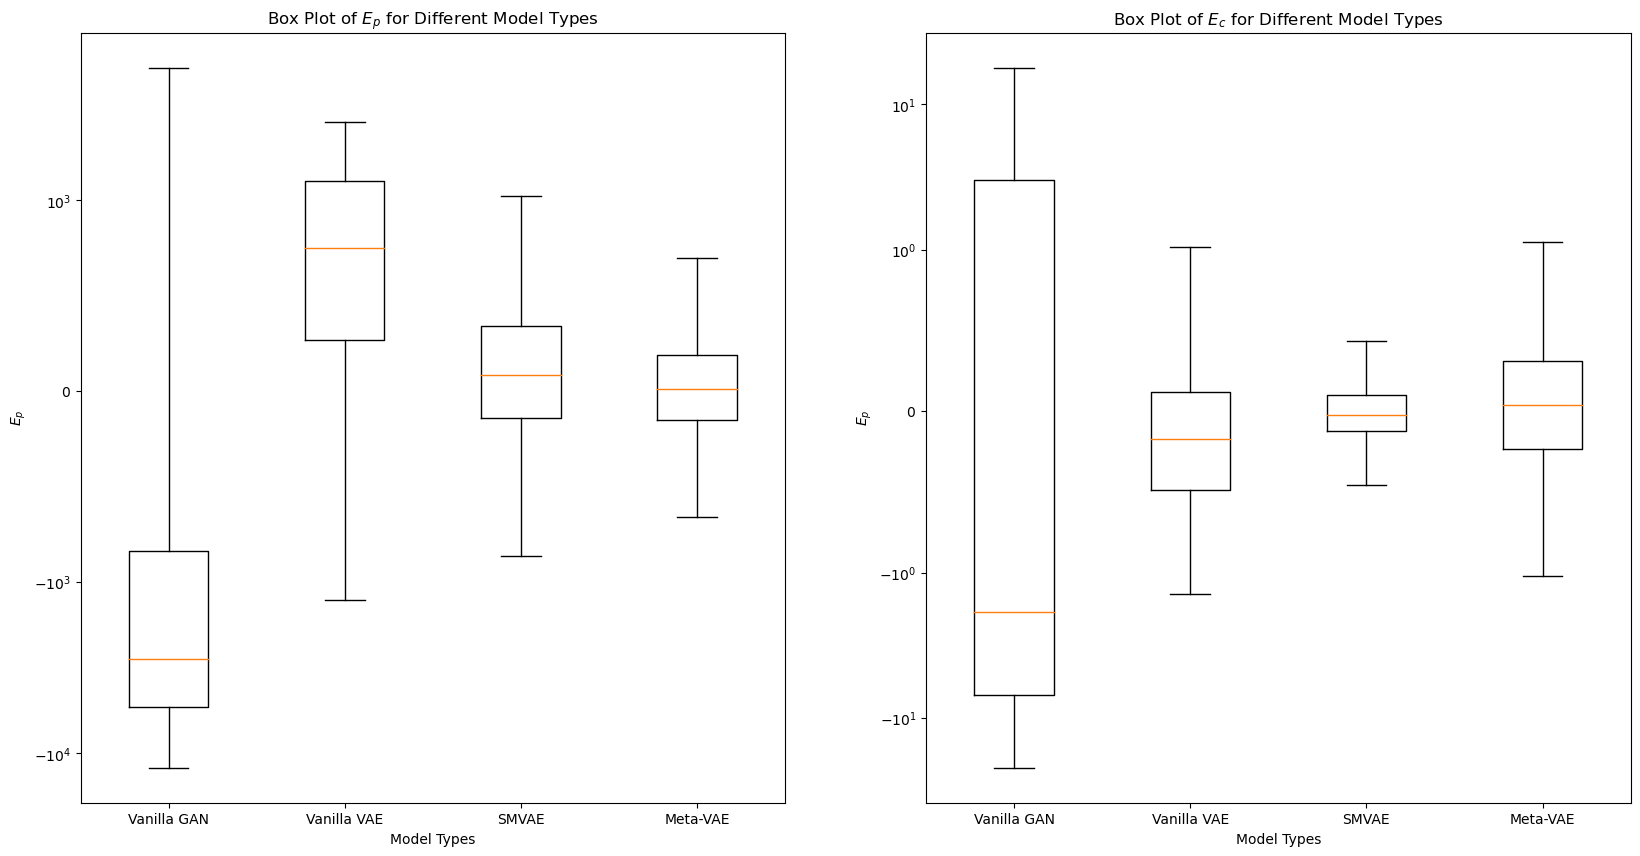

In [142]:
plot_box_plots(sample_mode = 'normal', mean=0, std=.3,whis=1.5,linthresh=[1000,1])

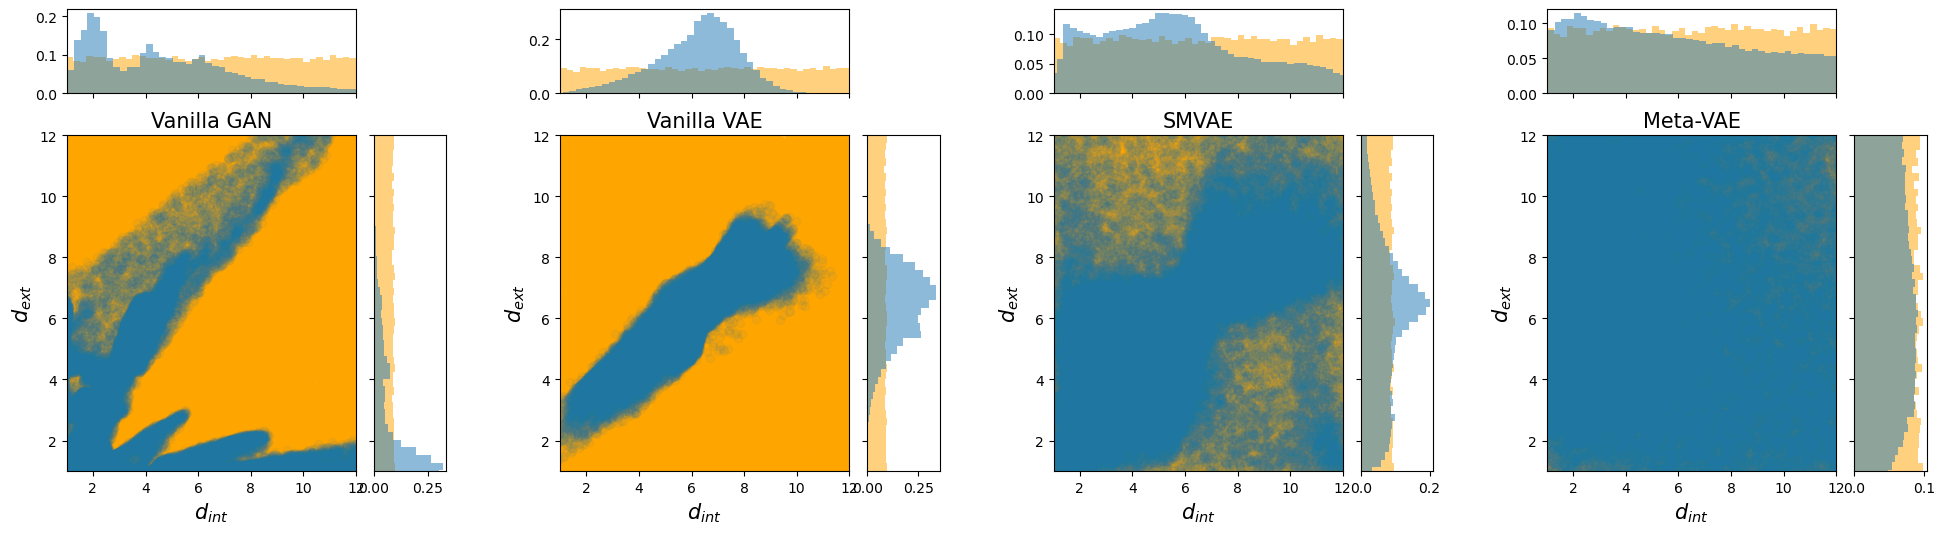

In [143]:
plot_joint_marginal_distributions('d1', 'd2', r'$d_{int}$',r'$d_{ext}$', 'real_d1', 'real_d2',(1,12),(1,12))#,
                                  # sample_mode = 'normal',bound = 2)

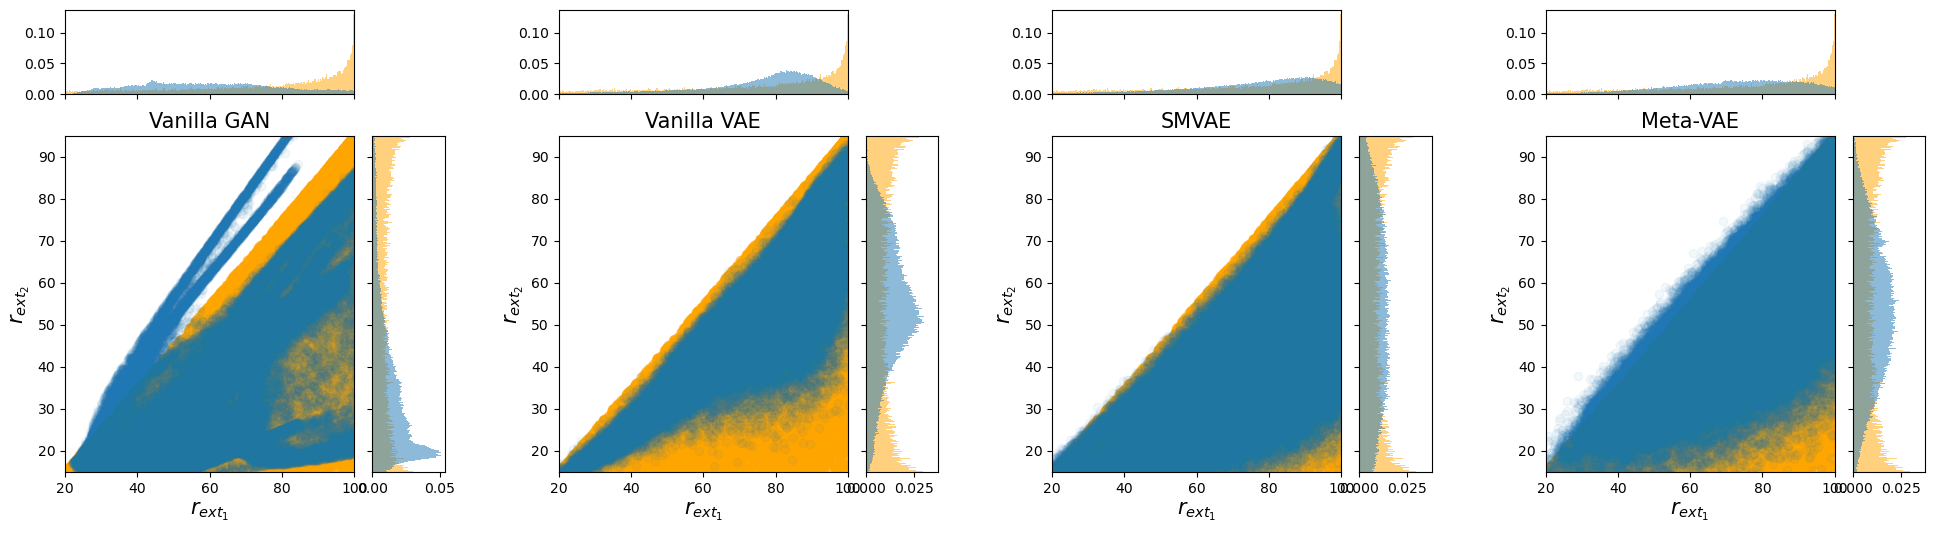

In [144]:
plot_joint_marginal_distributions('re1', 're2', r'$r_{ext_1}$',r'$r_{ext_2}$', 'real_re1', 'real_re2',(20,100),(15,95))#,
                                  # sample_mode = 'uniform',bound = 2)

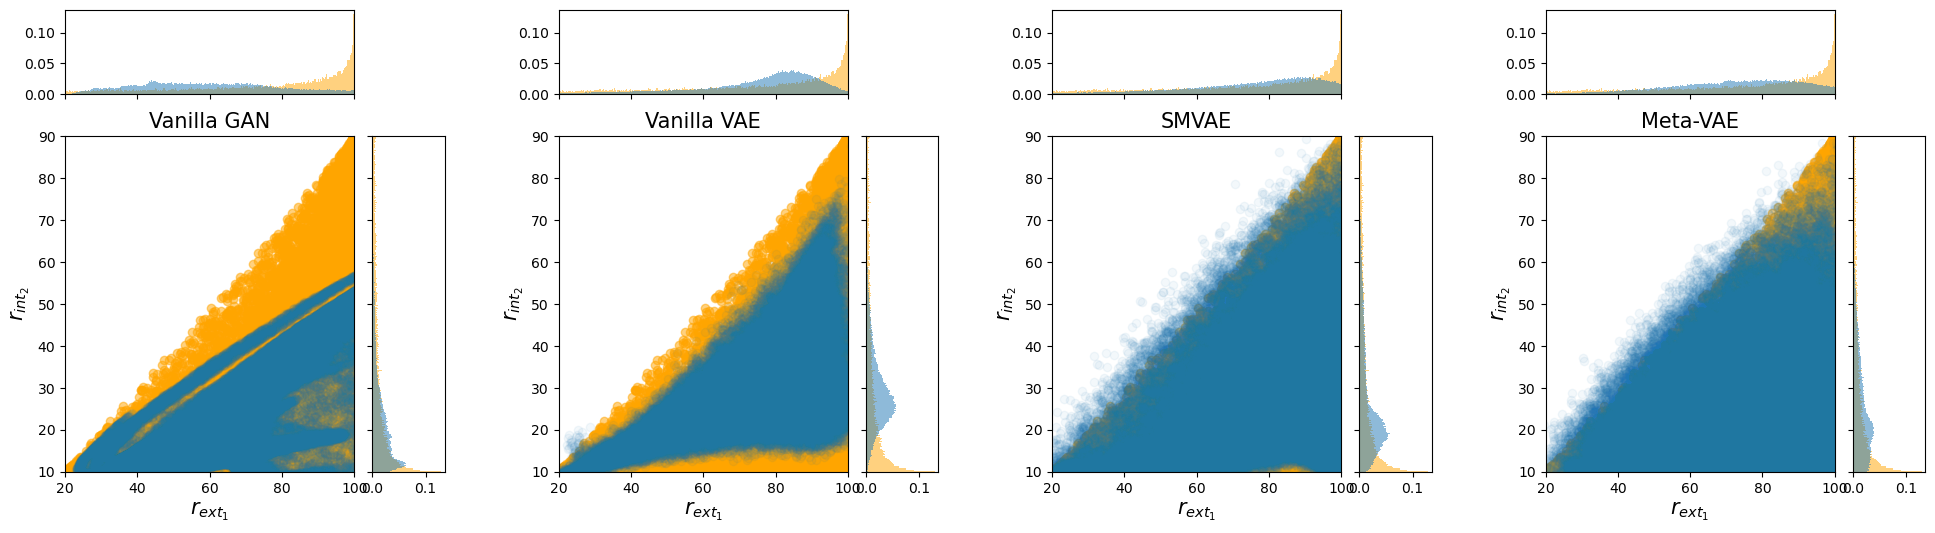

In [145]:
plot_joint_marginal_distributions('re1', 'ri2', r'$r_{ext_1}$',r'$r_{int_2}$','real_re1', 'real_ri2',(20,100),(10,90))#,
                                  # sample_mode = 'uniform',bound = 2)

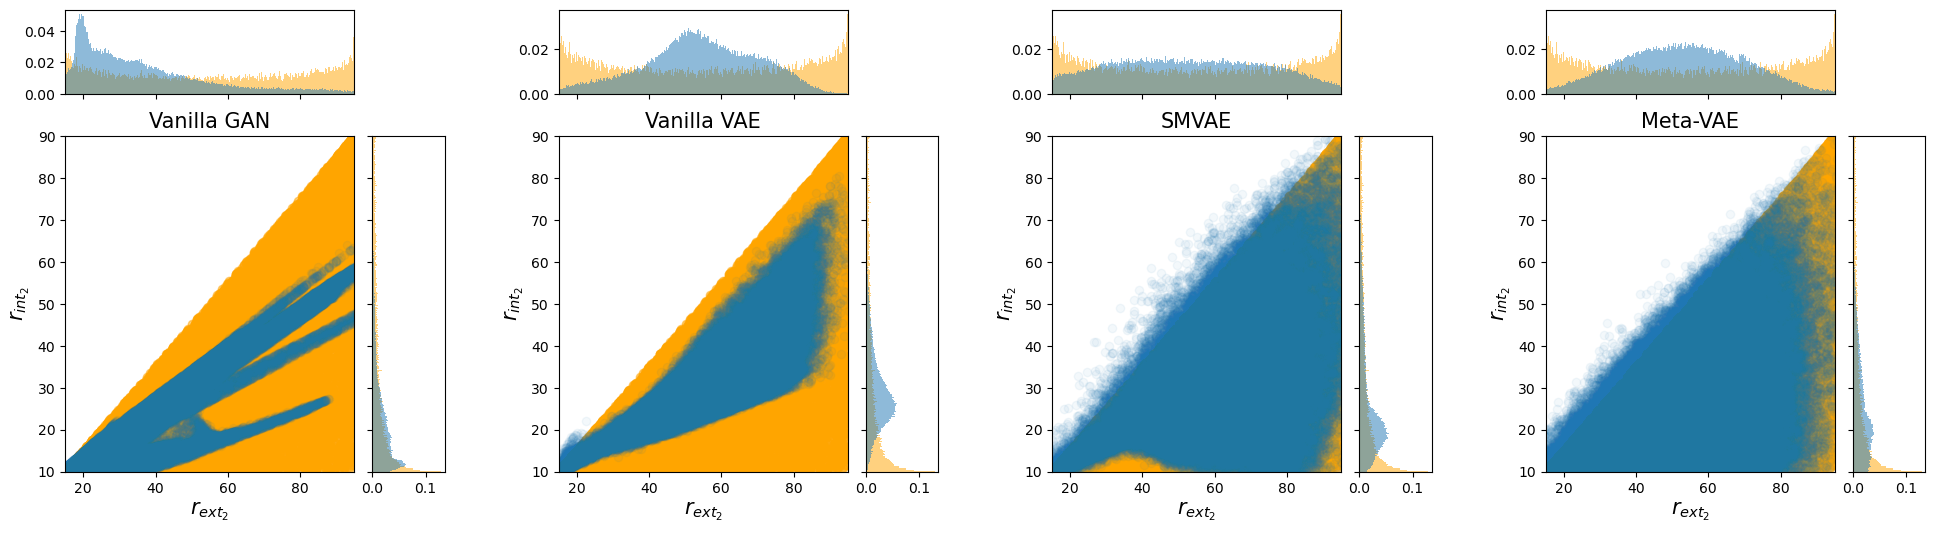

In [146]:
plot_joint_marginal_distributions('re2', 'ri2', r'$r_{ext_2}$',r'$r_{int_2}$', 'real_re2', 'real_ri2',(15,95),(10,90))#,
                                  # sample_mode = 'uniform',bound = 2)

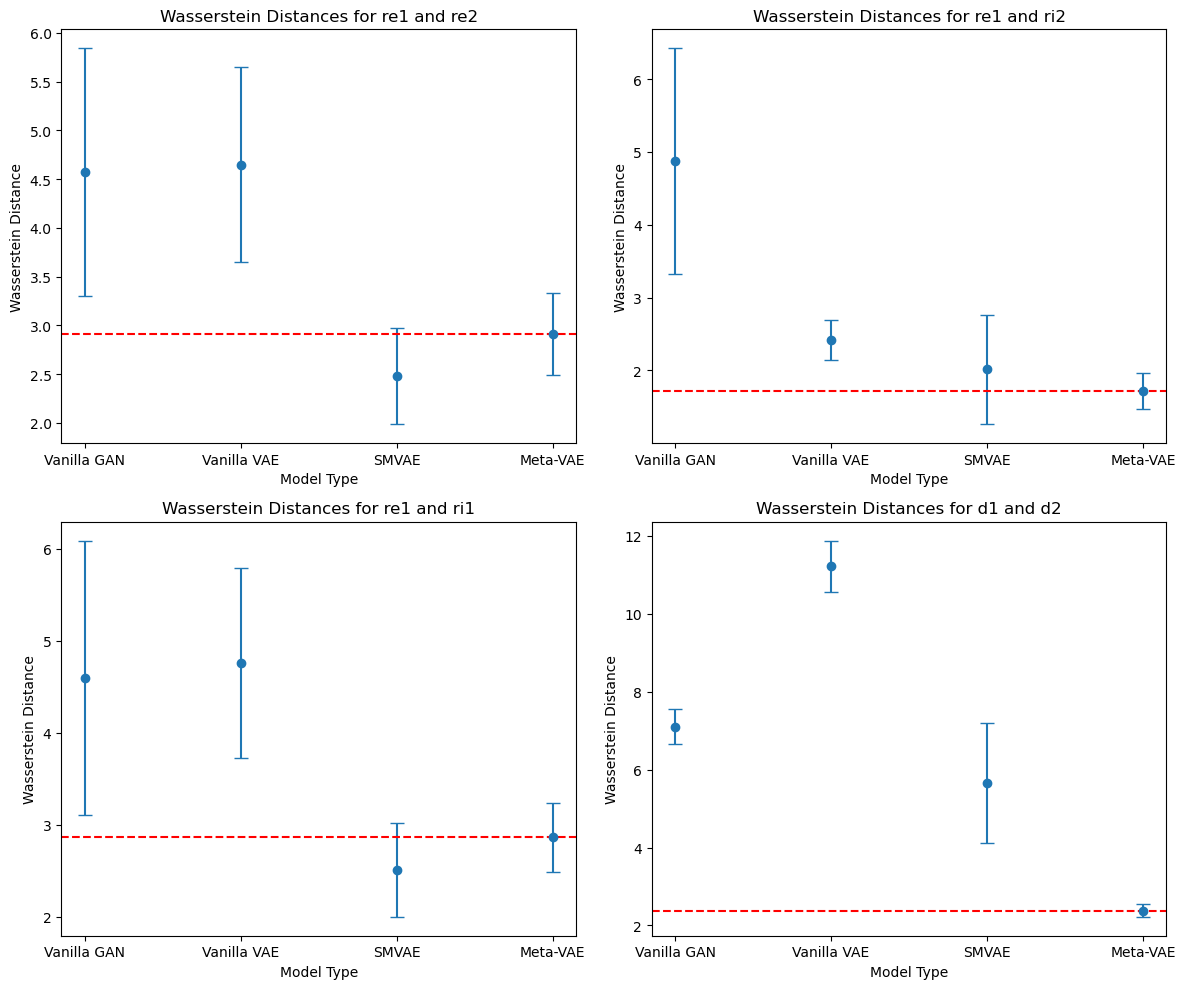

In [147]:
plot_wasserstein_errorbars(with_gan=True) 

### Generations plots

Cylinders

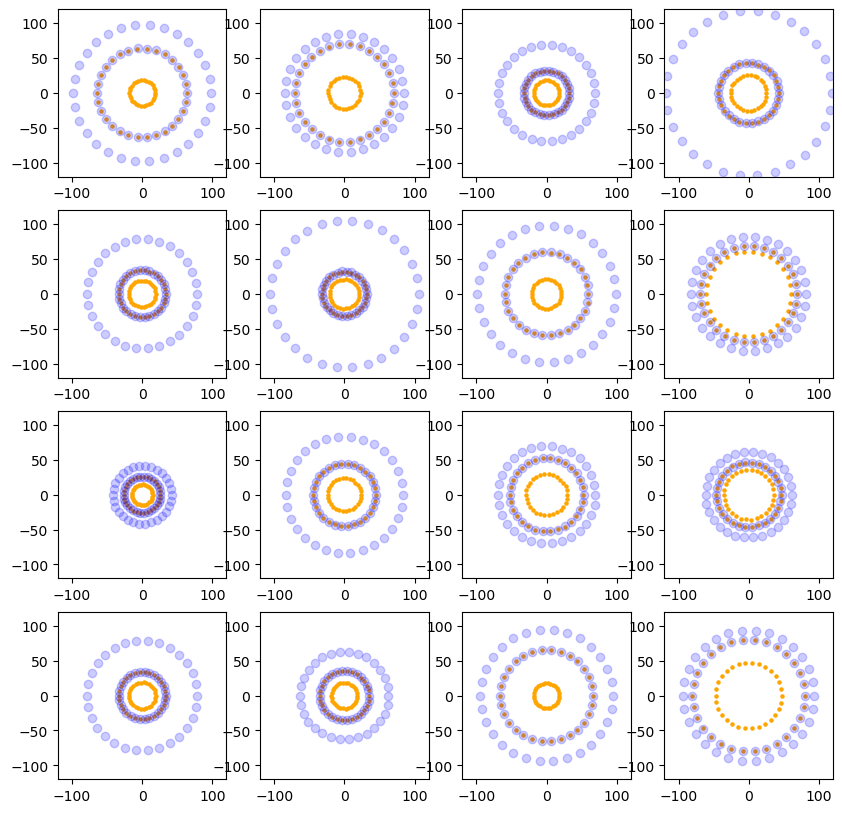

In [148]:
plot(svae_list[0],'svae')

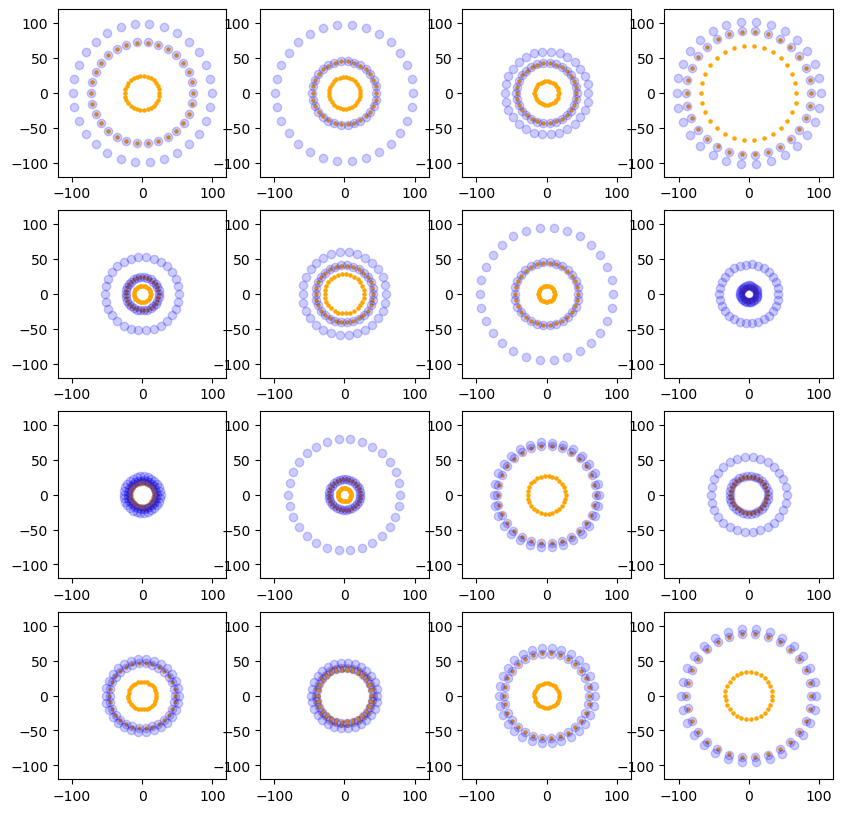

In [149]:
plot(mvae_list[0],'mvae')

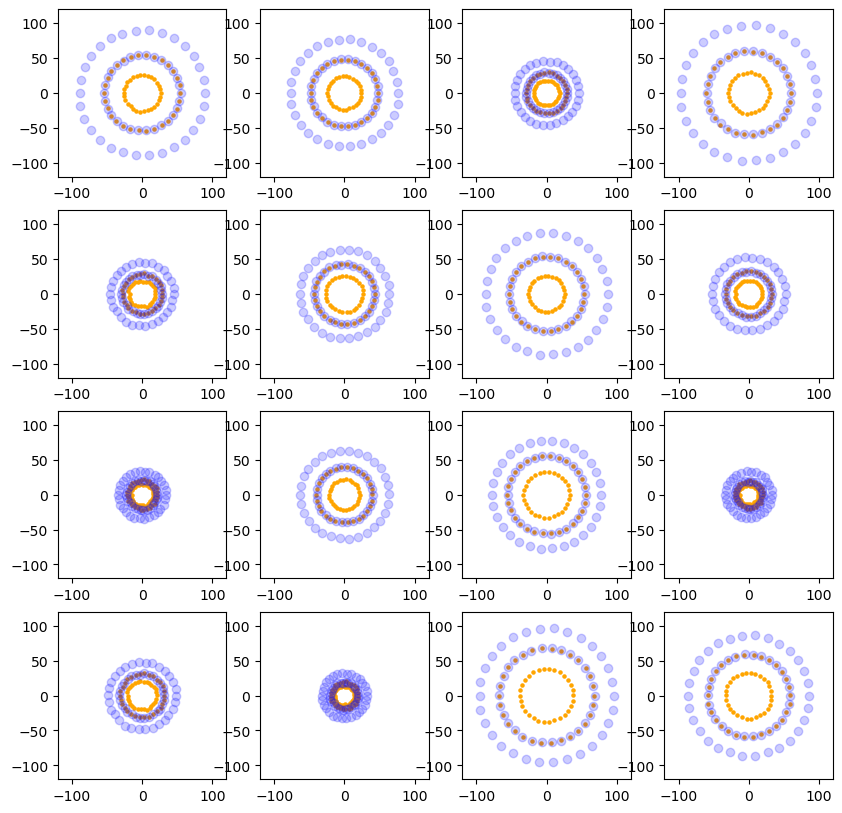

In [150]:
plot(vvae_list[0],'vvae')

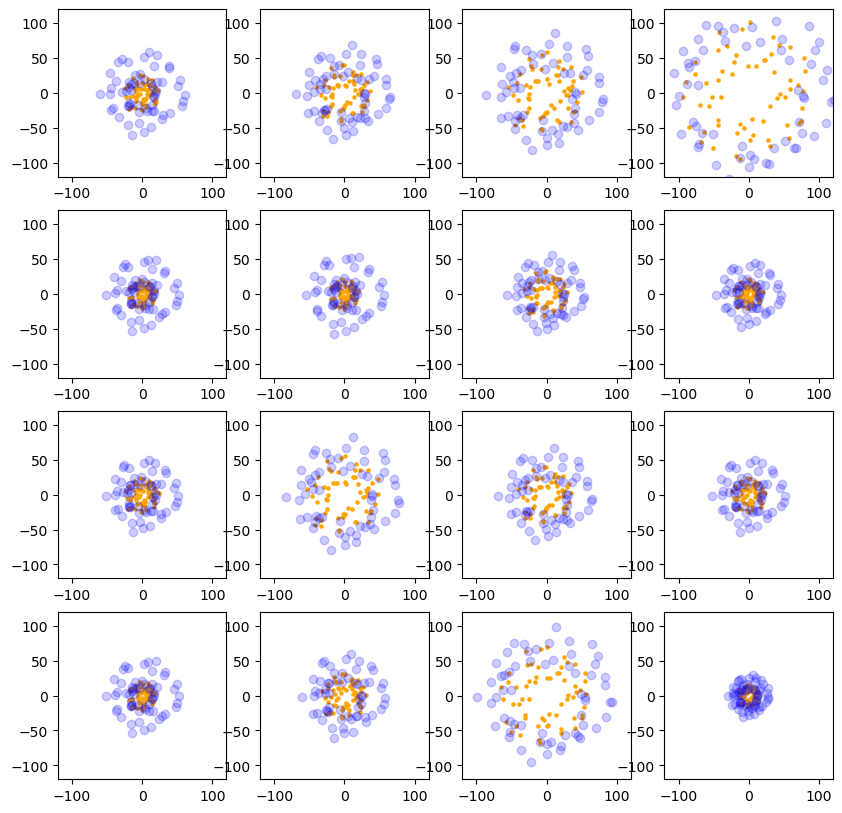

In [151]:
plot(gan_list[0],'gan')

Densities

In [152]:
plot(svae_list[0],'svae',is_cylinders=False)

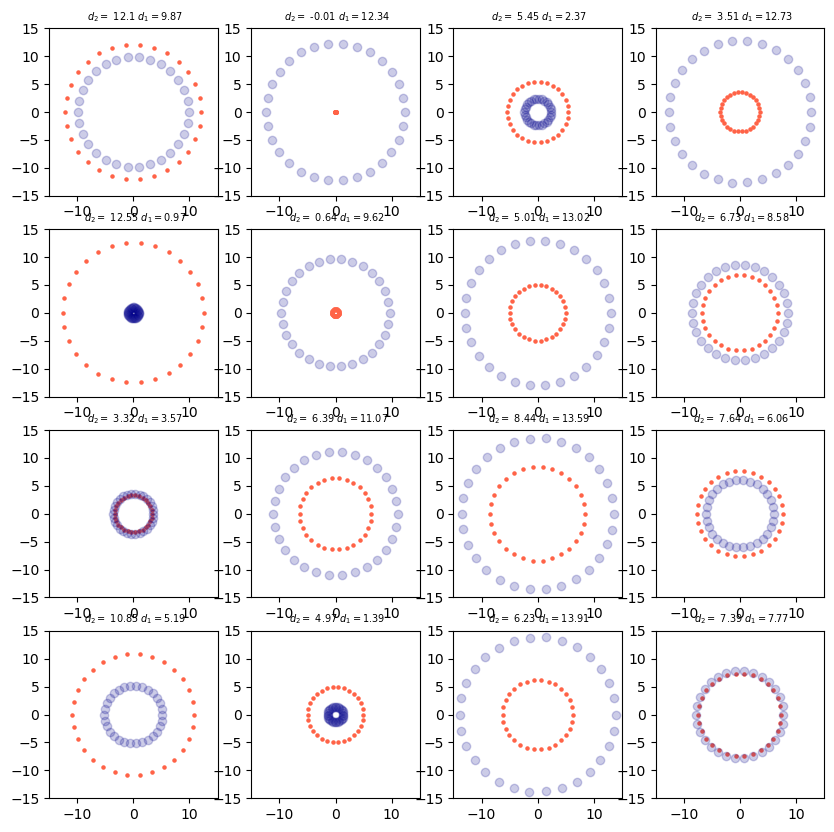

In [153]:
plot(mvae_list[0],'mvae',is_cylinders=False)

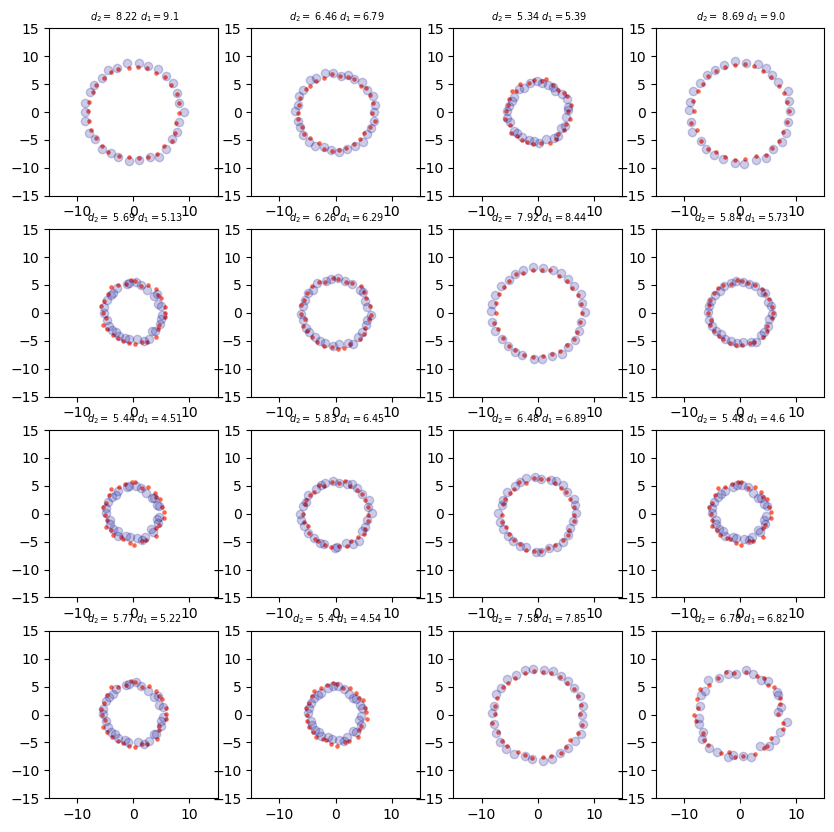

In [154]:
plot(vvae_list[0],'vvae',is_cylinders=False)

In [155]:
plot(gan_list[0],'gan',is_cylinders=False)

# Conditional generation

The condition corresponds to the hyperparameters $(m_{cube}, x)$ (refer to the paper for details). The subsequent figure illustrates the distribution of training hyperparameters, with the relationship $y = 1 - x$ being maintained. It is important to note that using hyperparameters outside of this distribution may lead to suboptimal results.

<div style="text-align: center;">
  <img src="../figures/x_m_cube.png" alt="Use case" width="600" height="400">
</div>

In [156]:
conditional = True
condition = (200,80)
n_cond = 1000

## Plots

### Errors and distributions plots

100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


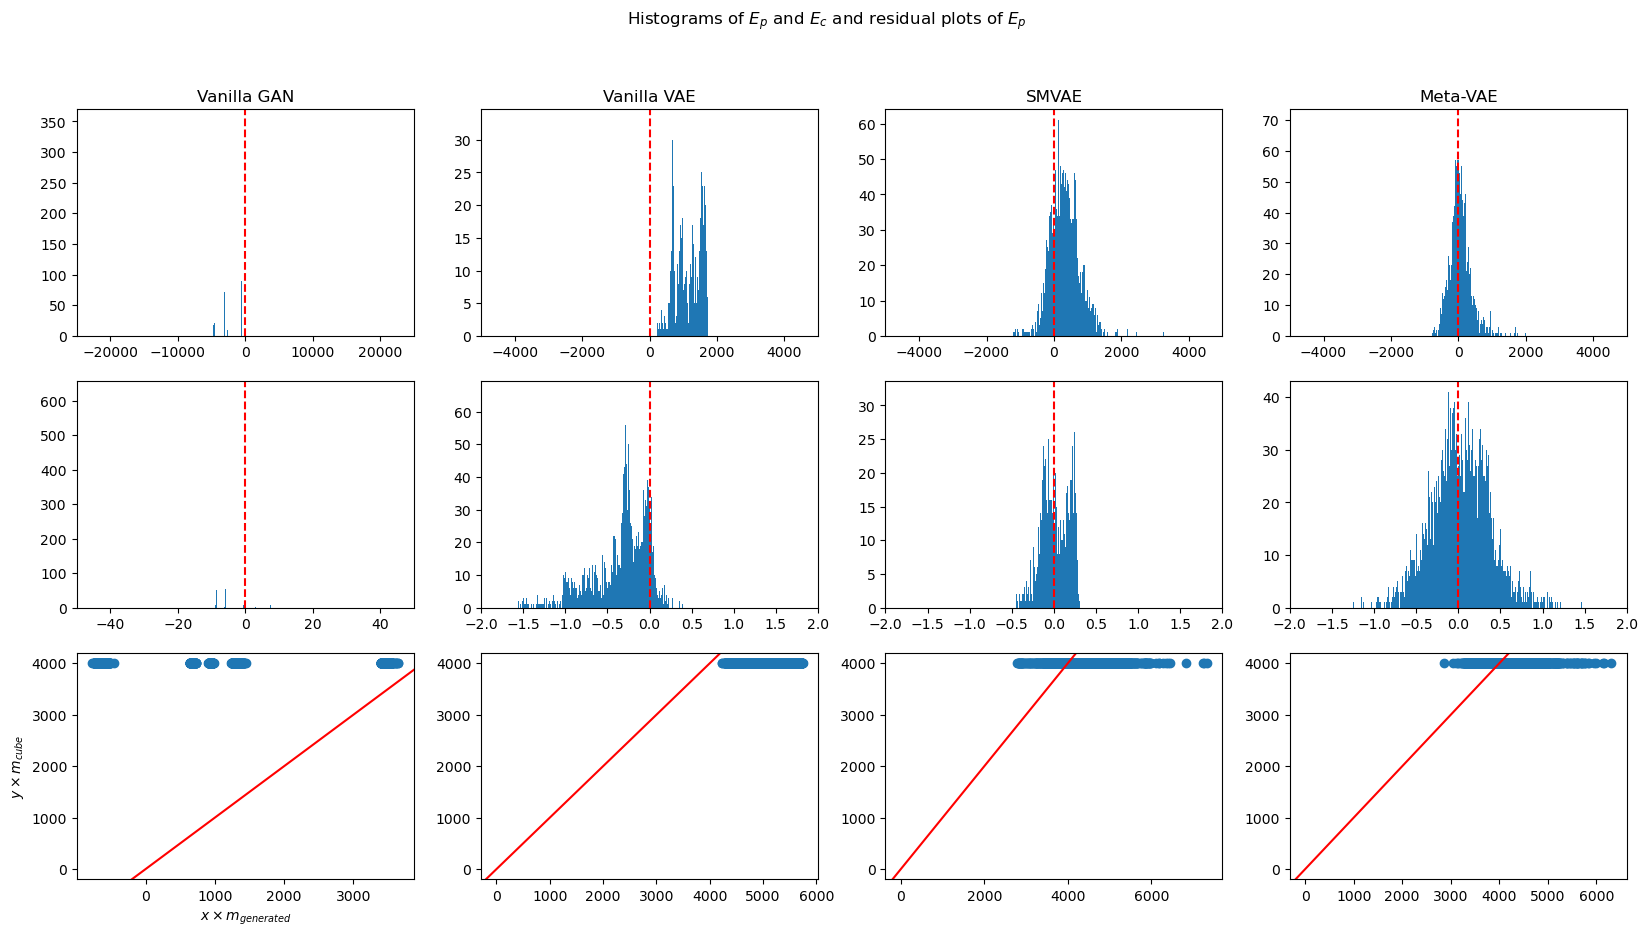

In [157]:
plot_errors(sample_mode = 'normal', mean=0, std=.3, conditional = conditional, condition = condition, n_cond = n_cond)

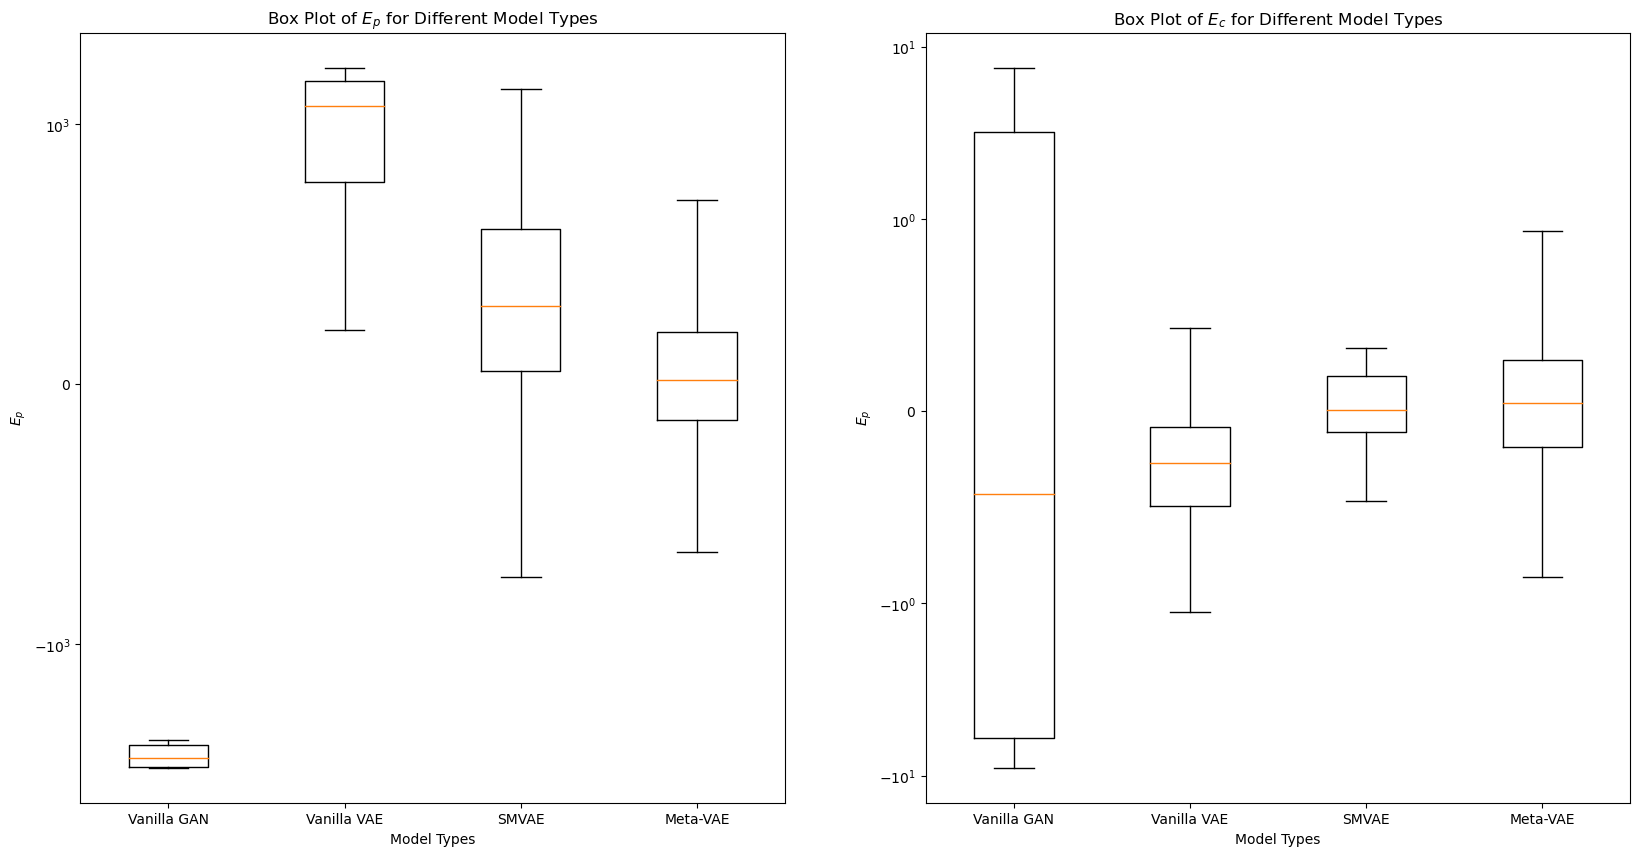

In [158]:
plot_box_plots(sample_mode = 'normal', mean=0, std=.3,whis=1.5,linthresh=[1000,1],conditional = conditional,
               condition = condition, n_cond = n_cond)

In [159]:
plot_joint_marginal_distributions('d1', 'd2', r'$d_{int}$',r'$d_{ext}$',xlim=(1,12),ylim=(1,12),
                                 conditional = conditional, condition = condition, n_cond = n_cond)

In [160]:
plot_joint_marginal_distributions('re1', 're2', 'real_re1', 'real_re2',xlim=(20,100),ylim=(15,95),
                                  conditional = conditional, condition = condition, n_cond = n_cond)

In [161]:
plot_joint_marginal_distributions('re1', 'ri2','real_re1', 'real_ri2',xlim=(20,100),ylim=(10,90),
                                  conditional = conditional, condition = condition, n_cond = n_cond)

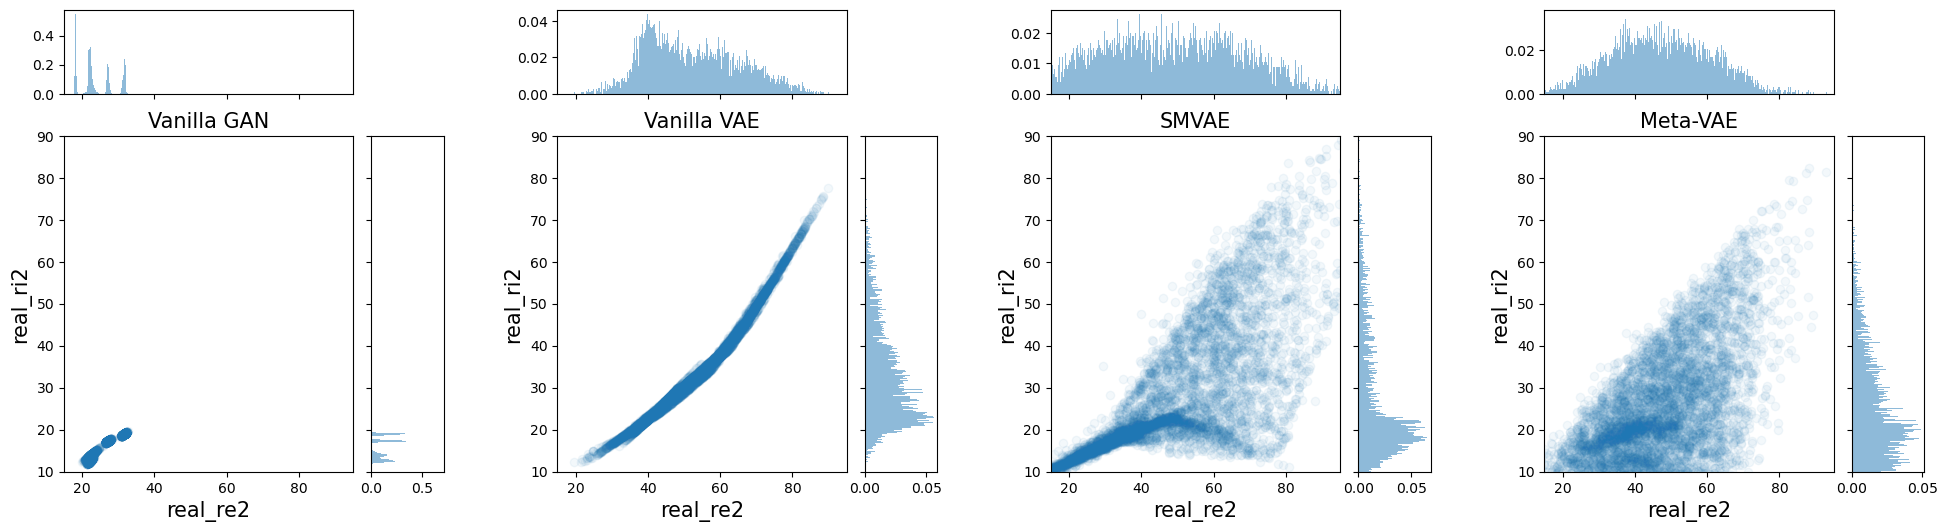

In [162]:
plot_joint_marginal_distributions('re2', 'ri2', 'real_re2', 'real_ri2',xlim=(15,95),ylim=(10,90),
                                  conditional = conditional, condition = condition, n_cond = n_cond)

### Generations plots

Cylinders

In [77]:
plot(svae_list[0],'svae', conditional = conditional, condition = condition)

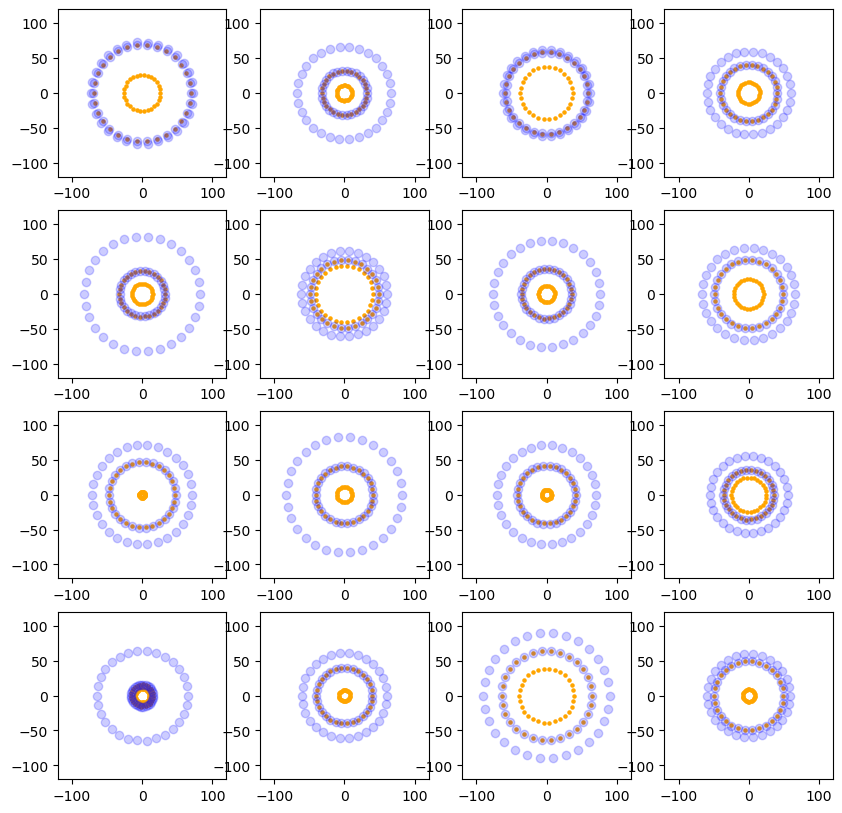

In [78]:
plot(mvae_list[0],'mvae', conditional = conditional, condition = condition)

In [79]:
plot(vvae_list[0],'vvae', conditional = conditional, condition = condition)

In [80]:
plot(gan_list[0],'gan', conditional = conditional, condition = condition)

Densities

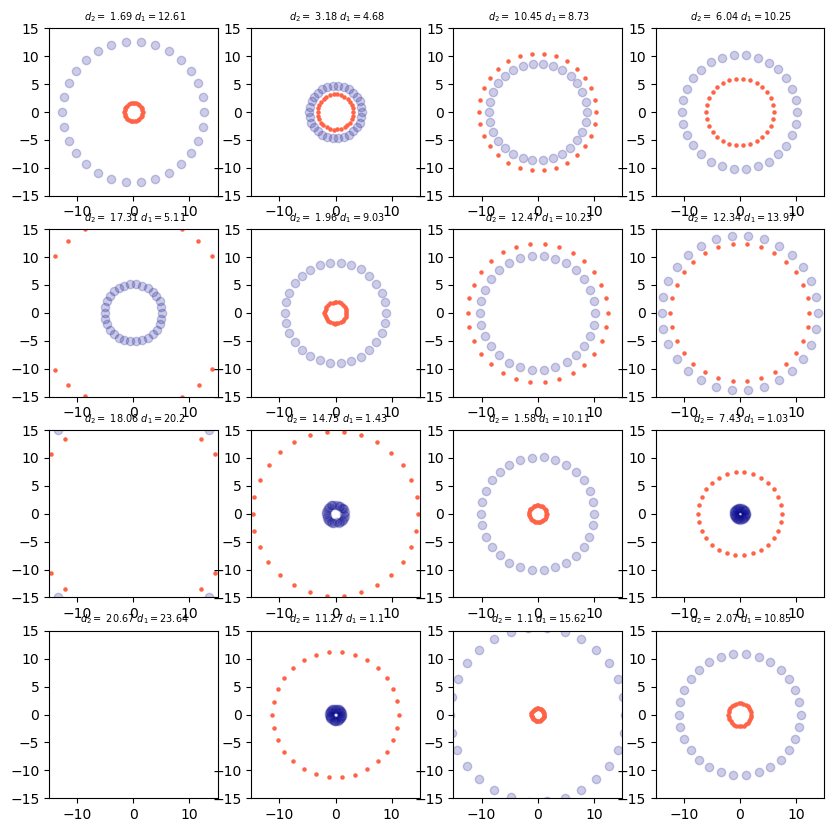

In [81]:
plot(svae_list[0],'svae',is_cylinders=False, conditional = conditional, condition = condition)

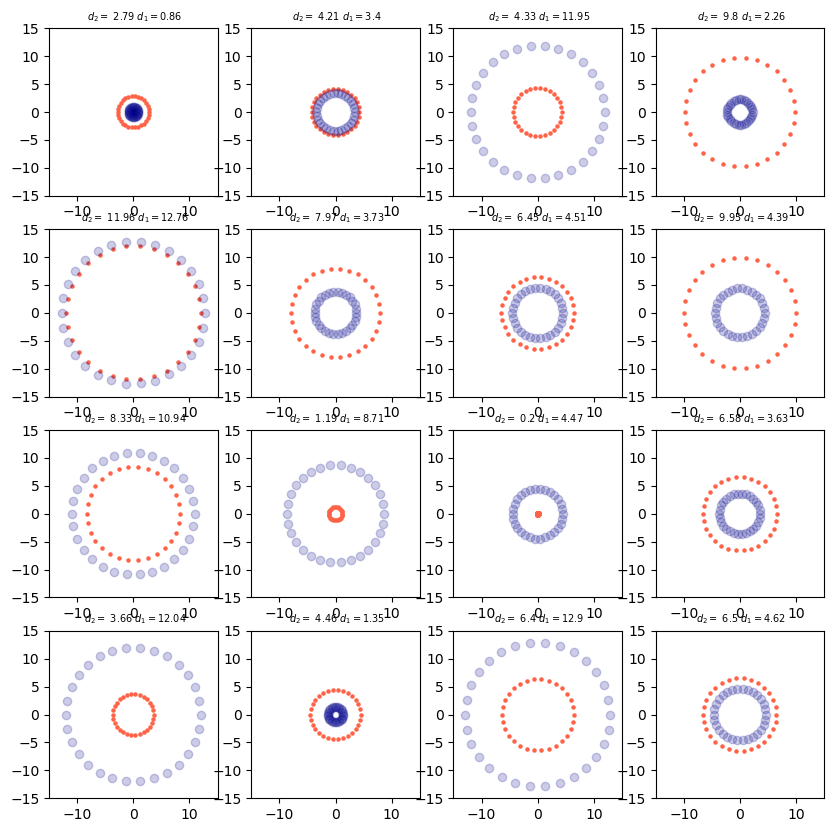

In [82]:
plot(mvae_list[0],'mvae',is_cylinders=False, conditional = conditional, condition = condition)

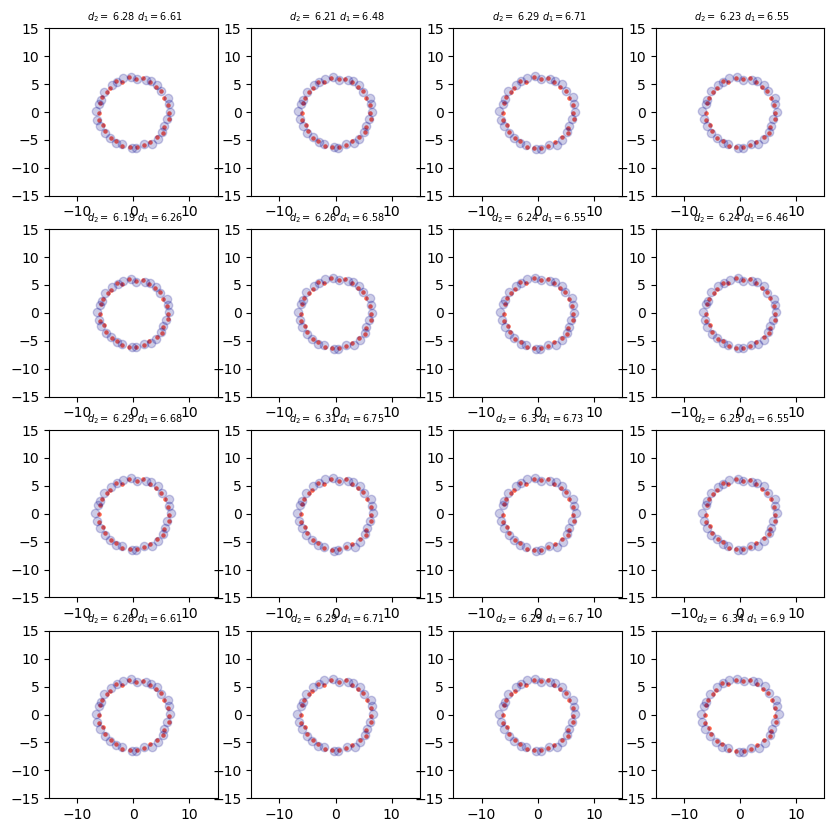

In [83]:
plot(vvae_list[0],'vvae',is_cylinders=False, conditional = conditional, condition = condition)

In [84]:
plot(gan_list[0],'gan',is_cylinders=False, conditional = conditional, condition = condition)

# Latent space visualization

In [ ]:
from sklearn.manifold import TSNE

In [38]:
# pip install -U scikit-learn

In [45]:
gen_mvae = generate_multiple(mvae_list,'Meta-VAE',std=.3)

In [86]:
gen_mvae.keys()

dict_keys(['error', 'r_err', 're1', 'ri1', 're2', 'ri2', 'd2', 'd1', 'mx', 'my', 'sample', 'real_ri2', 'real_re2', 'real_ri1', 'real_re1', 'real_d2', 'real_d1', 'h_param'])

In [59]:
gen_mvae['sample'][0].shape

(19998, 4)

In [117]:
d1 = np.stack(gen_mvae['d1'],axis=1)
d1 = d1.reshape(-1, 1)
d1.shape

(99990, 1)

In [118]:
d2 = np.stack(gen_mvae['d2'],axis=1)
d2 = d2.reshape(-1, 1)
d2.shape

(99990, 1)

In [104]:
re2 = np.stack(gen_mvae['re2'],axis=1)
re2 = re2.reshape(-1, 1)
re2.shape

(99990, 1)

In [102]:
re1 = np.stack(gen_mvae['re1'],axis=1)
re1 = re1.reshape(-1, 1)
re1.shape

(99990, 1)

In [88]:
r_err = np.stack(gen_mvae['r_err'],axis=1)
r_err = r_err.reshape(-1, 1)
r_err.shape

(99990, 1)

In [94]:
mx = np.stack(gen_mvae['mx'],axis=1)
mx = mx.reshape(-1, 1)
mx.shape

(99990, 1)

In [91]:
error = np.stack(gen_mvae['error'],axis=1)
error = error.reshape(-1, 1)
error.shape

(99990, 1)

In [ ]:
arr = []

In [81]:
sample = np.stack(gen_mvae['sample'],axis=1)
sample = sample.reshape(-1, sample.shape[-1])
sample.shape

(99990, 4)

## T-SNE

In [82]:
# sample_tsne = TSNE().fit_transform(sample)

In [107]:
plt.scatter(sample_tsne[:,0],sample_tsne[:,1],c = mx)
plt.title('T-SNE wrt mx')
plt.colorbar()
plt.show()

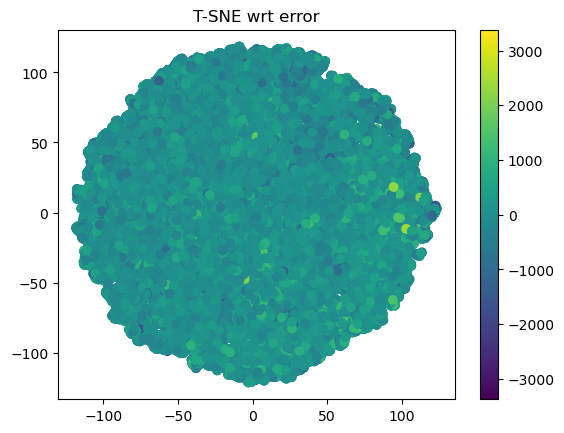

In [108]:
plt.scatter(sample_tsne[:,0],sample_tsne[:,1],c = error)
plt.title('T-SNE wrt error')
plt.colorbar()
plt.show()

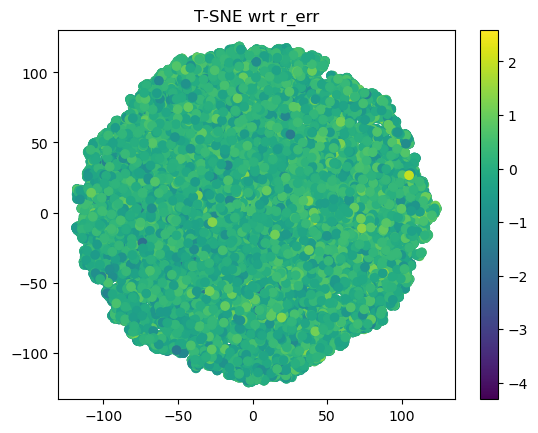

In [109]:
plt.scatter(sample_tsne[:,0],sample_tsne[:,1],c = r_err)
plt.title('T-SNE wrt r_err')
plt.colorbar()
plt.show()

In [110]:
plt.scatter(sample_tsne[:,0],sample_tsne[:,1],c = re2)
plt.title('T-SNE wrt re2')
plt.colorbar()
plt.show()

## PCA

In [96]:
from sklearn.decomposition import PCA

In [98]:
pca = PCA(n_components=2)
sample_pca = pca.fit_transform(sample)

In [111]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c = mx)
plt.title('PCA wrt mx')
plt.colorbar()
plt.show()

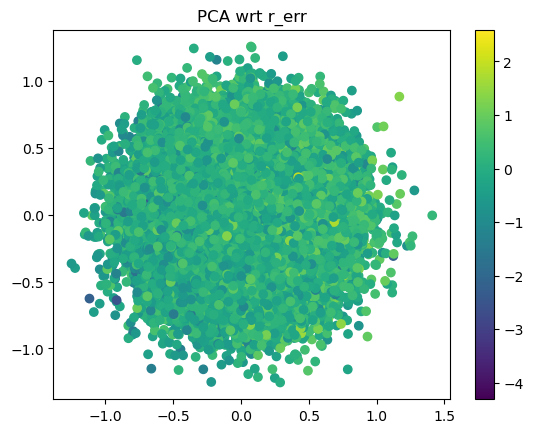

In [112]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c = r_err)
plt.title('PCA wrt r_err')
plt.colorbar()
plt.show()

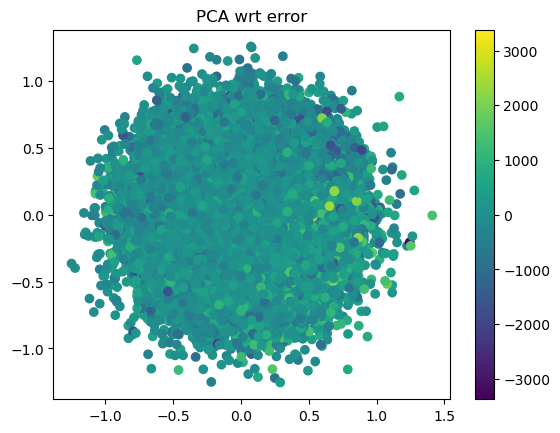

In [113]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c = error)
plt.title('PCA wrt error')
plt.colorbar()
plt.show()

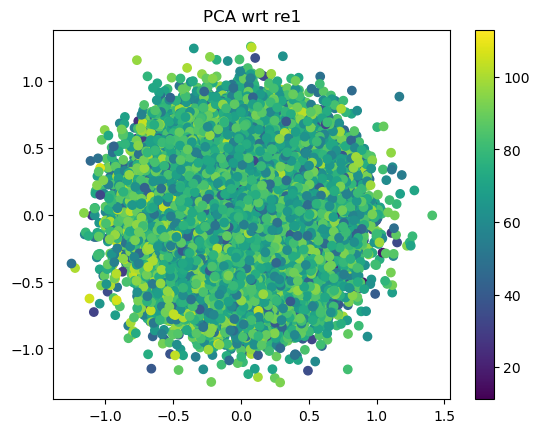

In [114]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c = re1)
plt.title('PCA wrt re1')
plt.colorbar()
plt.show()

In [115]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c = re2)
plt.title('PCA wrt re2')
plt.colorbar()
plt.show()

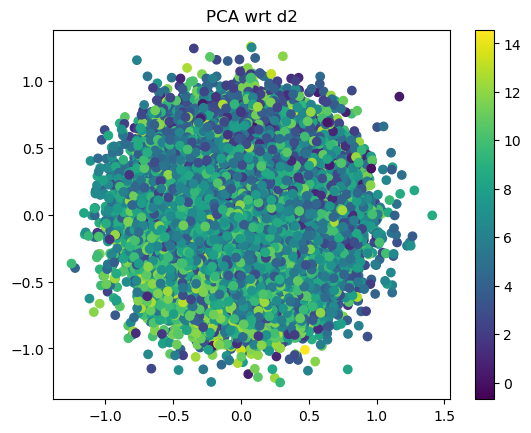

In [119]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c = d2)
plt.title('PCA wrt d2')
plt.colorbar()
plt.show()

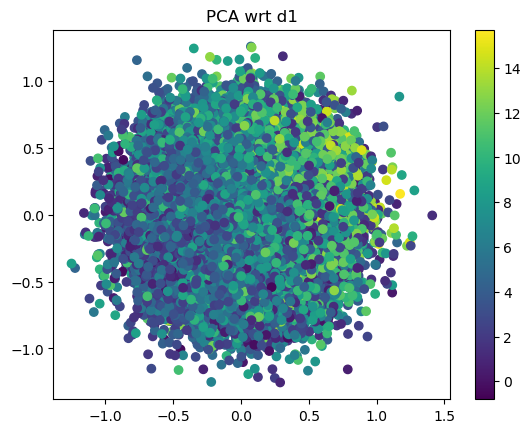

In [120]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c = d1)
plt.title('PCA wrt d1')
plt.colorbar()
plt.show()

# Ratios of correct generations

In [73]:
gen_mvae = generate_multiple(mvae_list,'Meta-VAE',std=.0001)

In [74]:
plt.hist(np.ravel(np.stack(gen_mvae['ri1'],axis=0))-np.ravel(np.stack(gen_mvae['re2'],axis=0)),bins=30)
plt.show()

In [75]:
r1_radii = np.ravel(np.stack(gen_mvae['ri1'],axis=0))
r2_radii = np.ravel(np.stack(gen_mvae['re2'],axis=0))

In [78]:
(abs(r1_radii-r2_radii)<.5).mean()

0.8392839283928393

(array([2.2000e+01, 1.3430e+03, 6.0302e+04, 3.8012e+04, 2.8600e+02,
        1.0000e+01, 8.0000e+00, 3.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([-0.06027244, -0.03932537, -0.01837831,  0.00256876,  0.02351582,
         0.04446288,  0.06540995,  0.08635701,  0.10730407,  0.12825114,
         0.1491982 ]),
 <BarContainer object of 10 artists>)

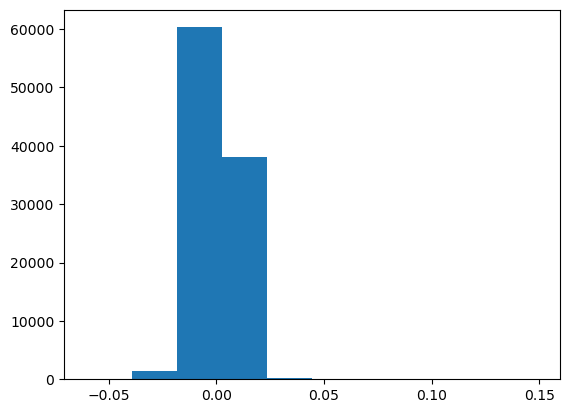

In [81]:
plt.hist((r1_radii-r2_radii)/r1_radii)